# Scan Maker

In this notebook we will show how to read an AOR and create scans starting from the information contained in the AOR.

The first case treated will be the AOR of an OTF observation.

We should be able to visualize the scans on a map to be sure that we are doing the right thing.

## How info is organized in the xml file of an AOR

It seems that:
1. the info is grouped into the tag: sspot.sofia.data.fifils.FIFI_LS_OTF
2. the <data> group contains all the data entered in uspot
3. <corners> contains the corners of the map
4. <mapPos> contains the beginning and end coordinates of each scan
5. <scanParams> contains the details of each scan (step, speed, direction)

# 1. Read the AOR

In [6]:
from xml.etree.ElementTree import ElementTree as ET

#aorfile = '../test/AorSgrA.aor'
aorfile = '/Users/dfadda/FIFI-LS/M101/75_0085_1tile.aor'
tree = ET(file=aorfile)


vector = tree.find('list/vector')
for child in vector:
    print(child.tag, child.attrib)
# Extract Target and Instrument from each AOR

targets = [item.text for item in vector.findall('Request/target/name')]
instruments = [item.text for item in vector.findall('Request/instrument/data/InstrumentName')]
print('instruments ',instruments)
print('targets ', targets)
print(vector[targets==target])

Request {}
instruments  ['FIFI-LS']
targets  ['M101s']
<Element 'Request' at 0x7fe5e4738f50>


In [7]:
abstract = tree.find('list/ProposalInfo/ProposalAbstract')
print('Abstract \n',abstract.text)
PropID = tree.find('list/ProposalInfo/ProposalID').text
print('prop ID: ', PropID)
PI = tree.find('list/ProposalInfo/Investigator')
PIname = PI.attrib['FirstName'] + ' ' + PI.attrib['LastName']
print('PI: ', PIname)

Abstract 
 This proposal will cover 25 square arcminutes of M101 using the OTF mapping mode of FIFI-LS to a 5-sigma [CII] sensitivity of 2.5E-16 W/m^2. Based on an earlier PACS strip through the galaxy, this should be sufficient to detect [CII] both in the center and in the disk.
prop ID:  75_0085
PI:  Robert Minchin


In [8]:
aorid = [item.text for item in vector.findall('Request/instrument/data/aorID')]
planmode = [item.text for item in vector.findall('Request/instrument/data/ObsPlanMode')]
primearray = [item.text for item in vector.findall('Request/instrument/data/PrimeArray')]
obslam = [item.text for item in vector.findall('Request/target/position/lon')]
obsbet= [item.text for item in vector.findall('Request/target/position/lat')]
maprotationangle = [item.text for item in vector.findall('Request/instrument/data/MapRotationAngle')]
print(maprotationangle)

['62.0']


idx  [[0]]
request  <Element 'Request' at 0x7fe5e9bf0110>
plan mode OTF_MAP
[]
det angle  62.0
det angle  62.0
RA, Dec  210.8 54.344722222222224
scanlength  240.0
mapoffsets  [[   0.    0.    0.    0. -240. -240. -240. -240.    0.    0.    0.    0.
  -240. -240. -240. -240. -210. -150.  -90.  -30.   30.   90.  150.  210.
    30.   90.  150.  210. -210. -150.  -90.  -30.]
 [  30.   90.  150.  210.   30.   90.  150.  210. -210. -150.  -90.  -30.
  -210. -150.  -90.  -30. -240. -240. -240. -240. -240. -240. -240. -240.
     0.    0.    0.    0.    0.    0.    0.    0.]]
rotated  [[  26.48842779   79.46528336  132.44213893  185.4189945   -86.18474728
   -33.20789171   19.76896386   72.74581943 -185.4189945  -132.44213893
   -79.46528336  -26.48842779 -298.09216957 -245.115314   -192.13845843
  -139.16160285 -310.49645047 -282.3281567  -254.15986294 -225.99156917
  -197.8232754  -169.65498164 -141.48668787 -113.3183941    14.08414688
    42.25244065   70.42073442   98.58902819  -98.58902819

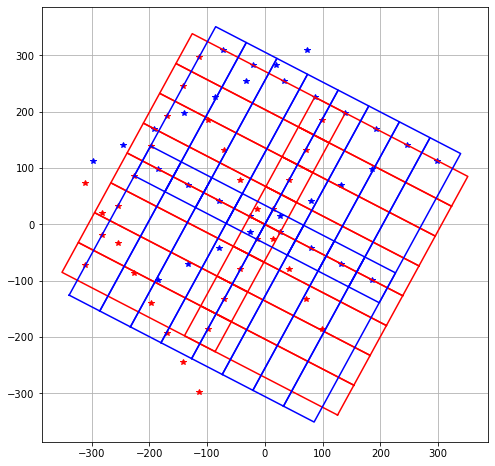

In [90]:
# Select one request based, e.g. on the target name (could be the aorid which is more unique)
# This is the case of map custom which is already a general case
# We should go back to the standard case of tiles
import numpy as np

title = 'Tile1234'

tree = ET(file=aorfile)
vector = tree.find('list/vector')
requests = [item for item in vector.findall('Request')]
titles = [item.text for item in vector.findall('Request/title')]
titles = np.array(titles)
idx = np.argwhere(titles==title)
request = requests[idx[0][0]]

print('idx ', idx)
print('request ' ,request)
print('plan mode', request.findall('instrument/data/ObsPlanMode')[0].text)
planmode = np.array(planmode)
print(planmode[targets==target])

# How to compute the detector angle
detangle = float(request.findall('instrument/data/MapRotationAngle')[0].text)
#print('detangle ', detangle[0].text)
#detangle = (((detangle + 11.3) + 180 + 360) % 360) - 180
print('det angle ', detangle)
#detangle = (((detangle ) + 180 + 360) % 360) - 180
detangle = (detangle + 360) % 360
print('det angle ', detangle)

scanpath = 'instrument/scanParams/sspot.sofia.data.fifils.ScanParameters/'
pos_lon = request.findall('target/position/lon')[0].text
pos_lat = request.findall('target/position/lat')[0].text
print('RA, Dec ', pos_lon, pos_lat)
dlam_map = [item.text for item in request.findall(scanpath+'deltaX')]
dbet_map = [item.text for item in request.findall(scanpath+'deltaY')]
skyspeed = [item.text for item in request.findall(scanpath+'scanSpeed')]
scandirection = [item.text for item in request.findall(scanpath+'scanDirection')]
scandirection = np.array(scandirection)
velangle = []
for sc in scandirection:
    if sc == '+X': 
        va = 90
    elif sc == '-X':
        va = 270
    elif sc == '+Y':
        va = 0
    elif sc == '-Y':
        va = 180
    velangle.append(va)
velangle = np.array(velangle, dtype=float)
    
detang = detangle * np.pi / 180.0
cosa = np.cos(detang)
sina = np.sin(detang)
r = np.array([[cosa, -sina], [sina, cosa]])
dlam_map = np.array(dlam_map, dtype='float')
dbet_map = np.array(dbet_map, dtype='float')

# We should plot the first and last FOV
# The first is a square of 1'x1' (red) or "x30" (blue) centered on the starting point
# For the last, we have to compute the distance v * t (6 arcsec/sec * 60s = 360 arcsec) and
# add it to the initial position
# Compute final positions

# Scan length (sec) is contained in TimePerPoint ?
scantime = float(request.findall('instrument/data/TimePerPoint')[0].text)
#scantime = 30
# To be read from scanParams/scanSpeed
velocity = 8 # arcsec/sec
distance = velocity * scantime
print('scanlength ', distance)
dlam_end = dlam_map.copy()
dbet_end = dbet_map.copy()


idx = scandirection == '+X'
if np.sum(idx) > 0:
    dlam_end[idx] += distance
idx = scandirection == '-X'
if np.sum(idx) > 0:
    dlam_end[idx] -= distance
idx = scandirection == '+Y'
if np.sum(idx) > 0:
    dbet_end[idx] += distance
idx = scandirection == '-Y'
if np.sum(idx) > 0:
    dbet_end[idx] -= distance

x1, y1 = dlam_map.copy(), dbet_map.copy()
x2, y2 = dlam_map.copy(), dbet_map.copy()
x3, y3 = dlam_end.copy(), dbet_end.copy()
x4, y4 = dlam_end.copy(), dbet_end.copy()
   
    
    
mapoffsets = np.array([dlam_map, dbet_map])
print('mapoffsets ', mapoffsets)
#rot_mapoffsets = np.dot(np.transpose(r), mapoffsets)
rot_mapoffsets = np.dot(r, mapoffsets)
print('rotated ' ,rot_mapoffsets)
mapends = np.array([dlam_end, dbet_end])
#rot_mapends = np.dot(np.transpose(r), mapends)
rot_mapends = np.dot(r, mapends)

# Find the corners
dr = 30 # case of red array, half side is 30 arcsec
idx = scandirection == '+X'
if np.sum(idx) > 0:
    x1[idx] -= dr
    x2[idx] -= dr
    x3[idx] += dr
    x4[idx] += dr
    y1[idx] += dr
    y2[idx] -= dr
    y3[idx] -= dr
    y4[idx] += dr
idx = scandirection == '-X'
if np.sum(idx) > 0:
    x1[idx] += dr
    x2[idx] += dr
    x3[idx] -= dr
    x4[idx] -= dr
    y1[idx] += dr
    y2[idx] -= dr
    y3[idx] -= dr
    y4[idx] += dr
idx = scandirection == '+Y'
if np.sum(idx) > 0:
    x1[idx] -= dr
    x2[idx] += dr
    x3[idx] += dr
    x4[idx] -= dr
    y1[idx] -= dr
    y2[idx] -= dr
    y3[idx] += dr
    y4[idx] += dr
idx = scandirection == '-Y'
if np.sum(idx) > 0:
    x1[idx] -= dr
    x2[idx] += dr
    x3[idx] += dr
    x4[idx] -= dr
    y1[idx] += dr
    y2[idx] += dr
    y3[idx] -= dr
    y4[idx] -= dr


xy1 = np.array([x1, y1])
xy2 = np.array([x2, y2])
xy3 = np.array([x3, y3])
xy4 = np.array([x4, y4])
#rxy1 = np.dot(np.transpose(r), xy1)
#rxy2 = np.dot(np.transpose(r), xy2)
#rxy3 = np.dot(np.transpose(r), xy3)
#rxy4 = np.dot(np.transpose(r), xy4)
rxy1 = np.dot(r, xy1)
rxy2 = np.dot(r, xy2)
rxy3 = np.dot(r, xy3)
rxy4 = np.dot(r, xy4)


# matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
xoff = rot_mapoffsets[0]
yoff = rot_mapoffsets[1]
xend = rot_mapends[0]
yend = rot_mapends[1]
idx = (velangle == 0) | (velangle == 270)
fig,ax = plt.subplots(figsize=(8,8))
ax.plot([xoff[idx],xend[idx]], [yoff[idx],yend[idx]], '*r')
ax.plot([xoff[~idx],xend[~idx]], [yoff[~idx],yend[~idx]], '*b')
 
idx = (velangle == 0) | (velangle == 270)  
ax.plot([rxy1[0][idx],rxy2[0][idx],rxy3[0][idx],rxy4[0][idx],rxy1[0][idx]], 
        [rxy1[1][idx],rxy2[1][idx],rxy3[1][idx],rxy4[1][idx],rxy1[1][idx]], color='red')
ax.plot([rxy1[0][~idx],rxy2[0][~idx],rxy3[0][~idx],rxy4[0][~idx],rxy1[0][~idx]], 
        [rxy1[1][~idx],rxy2[1][~idx],rxy3[1][~idx],rxy4[1][~idx],rxy1[1][~idx]], color='blue')
    

ax.grid()
plt.show()

In [69]:
import urllib, urllib.request
from io import BytesIO
from astropy.io import ascii,fits
from astropy.utils.data import download_file
def downloadWise(band, lon, lat, xsize, ysize):
        """ Download a Wise image """
        
        url = 'http://irsa.ipac.caltech.edu/ibe/search/wise/allsky/4band_p3am_cdd?POS='+\
                            "{0:.3f}".format(float(lon))+",{0:.3f}".format(float(lat))
        print(url)
        request = urllib.request.Request(url)
        response = urllib.request.urlopen(request)
        table = response.read()
        t = BytesIO(table)
        data = ascii.read(t,format='ipac')
        bands = data['band']
        coadds = data['coadd_id']
        bands = np.array(bands)
        coadds = np.array(coadds)
        coadd = coadds[bands == band]
        print(coadd)

        params = { 'coadd_id': coadd[0],'band': band,}
        params['coaddgrp'] = params['coadd_id'][:2]
        params['coadd_ra'] = params['coadd_id'][:4]
        path = str.format(
            '{coaddgrp:s}/{coadd_ra:s}/{coadd_id:s}/{coadd_id:s}-w{band:1d}-int-3.fits',
            **params)

        # We again specify center and size in WISE pixels (what is the pixel of WISE ? 1arcmin=45pix)
        #size=30,45arcsec
        #s1 = "{0:.0f}".format(pixscale[0]*60*ny*45)
        #s2 = "{0:.0f}".format(pixscale[1]*60*nx*45)
        s1 = "{0:.0f}".format(xsize*45)
        s2 = "{0:.0f}".format(ysize*45)

        url = 'http://irsa.ipac.caltech.edu/ibe/data/wise/allsky/4band_p3am_cdd/' + path+\
              "?center={0:.3f}".format(float(lon))+",{0:.3f}".format(float(lat))+"&size="+s1+','+s2+"pix&gzip=false"
        image_file = download_file(url,cache=True)

        with fits.open(image_file, memmap=False) as hdulist:
            header = hdulist['PRIMARY'].header
            data = hdulist['PRIMARY'].data
        return data, header


In [87]:
# Next: visualize on map
# 1. Transform center in (xc, yc)
# 2. Scale offsets to the size of image pixels
# 3. Add offsets to xc, yc and plot

from astroquery.skyview import SkyView
from astropy import units as u

# median position
lon = float(pos_lon)
lat = float(pos_lat)
mxoff = 0.5 * (np.nanmedian(xoff) + np.nanmedian(xend))
myoff = 0.5 * (np.nanmedian(yoff) + np.nanmedian(yend))
print(np.nanmedian(xoff), np.nanmedian(xend))
print('x,y off', mxoff, myoff)
myoff /= 3600.
mxoff /= 3600. / np.cos(lat * np.pi/180)

print('lon, lat' ,lon, lat)

lon += mxoff
lat += myoff

pos_lon = '{0:.5f}'.format(lon)
pos_lat = '{0:.5f}'.format(lat)


print('lon, lat' ,pos_lon, pos_lat)
dx = np.abs(np.nanmax(xend)-np.nanmin(xoff))
dy = np.abs(np.nanmax(yend)-np.nanmin(yoff))
npixels = int(np.nanmax([dx, dy]) * 1.5)
print('npixels ', npixels)

paths = SkyView.get_images(position=pos_lon+','+pos_lat, survey='DSS2 Red',
                           pixels=npixels) 
                           #width=0.05*u.deg, height=0.05*u.deg)
#paths = SkyView.get_images(position=pos_lon+','+pos_lat, survey='WISE 22', 
#                           pixels=1000, width=0.25*u.deg, height=0.25*u.deg)
#paths = SkyView.get_images(position=pos_lon+','+pos_lat, survey='2MASS-K', 
#                           pixels=1600, 
#                           width=0.25*u.deg, height=0.25*u.deg)

paths[0].writeto('../test/test.fits', overwrite=True)

23.12869582299652 -23.12869582299652
x,y off 0.0 0.0
lon, lat 210.8 54.34472
lon, lat 210.80000 54.34472
npixels  931


pix  0.99999972
center at  465.0 465.07200002018254


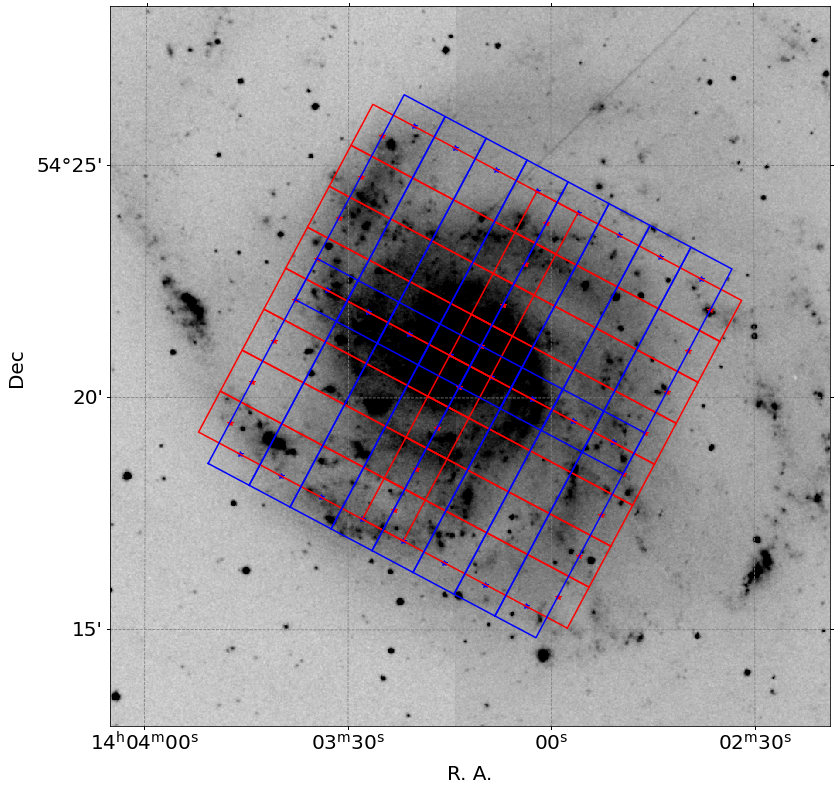

In [88]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales as pixscales

with fits.open('../test/test.fits') as hdul:
    image = hdul[0].data
    header = hdul[0].header
wcs = WCS(header)
pix = pixscales(wcs)[0]*3600. 
#xsize=ysize=20 # minutes
#image, header = downloadWise(1, pos_lon, pos_lat, xsize, ysize)
#wcs = WCS(header)
#pix = pixscales(wcs)[0]*3600. 
print('pix ', pix)


xc,yc = wcs.all_world2pix(float(pos_lon), float(pos_lat), 0)
print('center at ', xc, yc)

# Map
fig = plt.figure(figsize = (10,10))
ax = fig.add_axes([0.,0.,1.,1.], projection = wcs)
ax.coords[0].set_major_formatter('hh:mm:ss')
ax.set_xlabel('R. A.', fontsize=20)
ax.set_ylabel('Dec', fontsize=20)
ax.tick_params(axis='x', labelsize=20 )
ax.tick_params(axis='y', labelsize=20 )
image -= np.nanmedian(image)
ax.imshow(image, origin='lower',interpolation='nearest',cmap='gray_r', vmax=np.nanmax(image)*0.3)
ax.grid(color='gray', ls='dashed')


xo = xoff/pix
xe = xend/pix
yo = yoff/pix
ye = yend/pix
r1, r2, r3, r4 = rxy1/pix, rxy2/pix, rxy3/pix, rxy4/pix

idx = (velangle == 0) | (velangle == 270)  
ax.plot([xo[idx],xe[idx]]+xc, [yo[idx],ye[idx]]+yc, '*r')
ax.plot([xo[~idx],xe[~idx]]+xc, [yo[~idx],ye[~idx]]+yc, '*b')
ax.plot([r1[0][idx],r2[0][idx],r3[0][idx],r4[0][idx],r1[0][idx]]+xc, 
        [r1[1][idx],r2[1][idx],r3[1][idx],r4[1][idx],r1[1][idx]]+yc, color='red')
ax.plot([r1[0][~idx],r2[0][~idx],r3[0][~idx],r4[0][~idx],r1[0][~idx]]+xc, 
        [r1[1][~idx],r2[1][~idx],r3[1][~idx],r4[1][~idx],r1[1][~idx]]+yc, color='blue')

plt.show()

# Wavelength calibration

In [25]:
header_list = ["Date", "ch", "g0","NP","a","PS","QOFF","QS",
               "I1","I2","I3","I4","I5","I6","I7","I8","I9","I10",
               "I11","I12","I13","I14","I15","I16","I17","I18","I19","I20",
               "I21","I22","I23","I24","I25"]

wvdf = pd.read_csv(os.path.join(path, 'FIFI_LS_WaveCal_Coeffs.txt'), 
                   comment='#', delimiter='\s+', names=header_list)
wvdf

,Date,ch,g0,NP,a,PS,QOFF,QS,I1,I2,...,I16,I17,I18,I19,I20,I21,I22,I23,I24,I25
0,20140201,R105,0.117160,14.272374,421.441201,0.000587,6.141075,0.000002,9.535810e+05,9.537250e+05,...,9.527942e+05,9.526816e+05,9.526202e+05,9.525463e+05,9.526911e+05,9.535062e+05,9.533390e+05,9.531816e+05,9.530335e+05,9.531655e+05
1,20140201,R130,0.117127,14.725756,439.433868,0.000586,6.462990,0.000002,9.541718e+05,9.542901e+05,...,9.534953e+05,9.533698e+05,9.533073e+05,9.532536e+05,9.533479e+05,9.541621e+05,9.539938e+05,9.538517e+05,9.537239e+05,9.537924e+05
2,20140201,B1,0.082659,13.854585,730.359147,0.000553,6.818688,0.000011,1.075031e+06,1.074883e+06,...,1.074583e+06,1.074452e+06,1.074423e+06,1.074420e+06,1.074251e+06,1.074884e+06,1.074725e+06,1.074658e+06,1.074638e+06,1.074450e+06
3,20140201,B2,0.082662,14.297171,786.305018,0.000557,6.482488,0.000008,1.074856e+06,1.074808e+06,...,1.074491e+06,1.074421e+06,1.074405e+06,1.074379e+06,1.074170e+06,1.074775e+06,1.074665e+06,1.074608e+06,1.074587e+06,1.074338e+06
4,20141101,R105,0.117161,14.125583,425.488379,0.000587,5.881618,0.000002,9.543276e+05,9.544818e+05,...,9.535008e+05,9.533965e+05,9.533397e+05,9.532872e+05,9.535637e+05,9.541963e+05,9.540253e+05,9.538747e+05,9.537635e+05,9.539974e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,20210301,B2,0.082661,14.447050,756.755398,0.000558,6.524857,0.000008,1.075346e+06,1.075121e+06,...,1.074882e+06,1.074698e+06,1.074671e+06,1.074654e+06,1.074525e+06,1.075190e+06,1.074960e+06,1.074897e+06,1.074869e+06,1.074720e+06
72,20210501,R105,0.117162,14.281500,424.797000,0.000585,5.976350,0.000002,1.150584e+06,1.150729e+06,...,1.149826e+06,1.149705e+06,1.149642e+06,1.149572e+06,1.149736e+06,1.150519e+06,1.150351e+06,1.150199e+06,1.150054e+06,1.150215e+06
73,20210501,R130,0.117149,14.298400,429.231000,0.000587,5.645390,0.000001,1.150914e+06,1.151055e+06,...,1.150159e+06,1.150049e+06,1.149990e+06,1.149925e+06,1.150075e+06,1.150839e+06,1.150680e+06,1.150536e+06,1.150399e+06,1.150523e+06
74,20210501,B1,0.082655,14.001000,875.423000,0.000550,6.598610,0.000011,1.075089e+06,1.074957e+06,...,1.074664e+06,1.074568e+06,1.074569e+06,1.074565e+06,1.074334e+06,1.074935e+06,1.074802e+06,1.074732e+06,1.074732e+06,1.074494e+06


In [26]:
import time
year =  str(time.gmtime().tm_year)
month = str(time.gmtime().tm_mon)
day = str(time.gmtime().tm_mday)
obsdate = year+month+day
print(obsdate)

20211127


In [45]:
dates = np.unique(wvdf['Date'])
obsdate = '20200802'
idx = dates < int(obsdate)
caldate = np.max(dates[idx])

channel = 'R105'

In [49]:
idx = (wvdf["Date"] == caldate) & (wvdf["ch"] == channel)
wcal = wvdf.loc[idx]

In [57]:
wcal['g0'].values[0]

0.117155379

In [64]:
print(np.shape(wcal.iloc[0][8:].values))

(25,)


In [75]:
from astropy.io import fits
with fits.open(os.path.join(path, 'atran_41K_40deg_7pwv_40-300mum.fits.gz')) as hdul:
    data = hdul[0].data
    hdul.info()

Filename: /Users/dfadda/Python/fififly/fififly/scanmaker/data/atran_41K_40deg_7pwv_40-300mum.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      21   (227710, 3)   float32   


(156.0, 160.0)

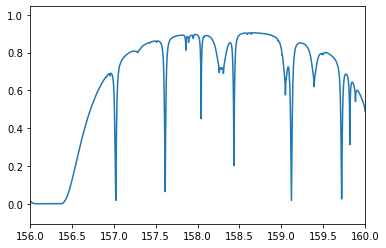

In [80]:
plt.plot(data[0,:], data[1,:])
plt.xlim(156,160)

In [81]:
print(np.tan(75 * np.pi/180))

3.7320508075688776


In [63]:
print(np.arctan(1/5)*180/np.pi)

11.309932474020213


In [89]:
message = 'aaa'
print(message.upper())

AAA


# Test of unidecode

In [3]:
from unidecode import unidecode

In [4]:
string = 'Bendré'
unidecode(string)

'Bendre'

In [5]:
unidecode('Dario Fadda')

'Dario Fadda'